# Notebook for training a convolutional neural network based on pre-trained VGG19 (transfer learning) for binary classification of spectrograms from voice audio recording

In [1]:

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools




In [2]:
data_labels = pd.read_csv('COVAREP_and_depression_data_mean.csv')

patientId = 300
data_labels['PHQ8_Binary'] = data_labels['PHQ8_Binary'].astype(int)
# print(int(data_labels.loc[data_labels['patientId'] == patientId, 'PHQ8_Binary'].values[0]))

labels = data_labels['PHQ8_Binary']

sum(labels)/len(labels)

0.2962962962962963

In [3]:
# Declare constants
IMAGE_HEIGHT = 244 #640
IMAGE_WIDTH = 244 #480
BATCH_SIZE = 64
N_CHANNELS = 3
N_CLASSES = 1
val_split = 0.3

OUTPUT_DIR = 'spectrograms/10s'

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=10)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(directory = OUTPUT_DIR,
                                             batch_size=BATCH_SIZE,
                                             validation_split=val_split,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=10)



Found 8664 files belonging to 2 classes.
Using 6065 files for training.
Found 8664 files belonging to 2 classes.
Using 2599 files for validation.


In [4]:
# from glob import glob 
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, RandomCrop
from tensorflow.keras.models import Model

IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)

# Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
# vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG19(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(1, activation='sigmoid')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes
#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [5]:
class_weights = {
  0: 0.304,
  1: 0.696,
}
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy']) 
history = model.fit(train_dataset, validation_data=valid_dataset, epochs=20, batch_size=64, class_weight=class_weights)

Epoch 1/20


2023-01-26 16:56:38.728185: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


95/95 [==============================] - 1155s 12s/step - loss: 0.4627 - accuracy: 0.5258 - val_loss: 0.8818 - val_accuracy: 0.5694
Epoch 2/20
95/95 [==============================] - 1116s 12s/step - loss: 0.3577 - accuracy: 0.5815 - val_loss: 0.8333 - val_accuracy: 0.5779
Epoch 3/20
95/95 [==============================] - 1110s 12s/step - loss: 0.3087 - accuracy: 0.6223 - val_loss: 0.7194 - val_accuracy: 0.6337
Epoch 4/20
95/95 [==============================] - 1111s 12s/step - loss: 0.2764 - accuracy: 0.6655 - val_loss: 0.6976 - val_accuracy: 0.6345
Epoch 5/20
95/95 [==============================] - 1109s 12s/step - loss: 0.2529 - accuracy: 0.6932 - val_loss: 0.6715 - val_accuracy: 0.6526
Epoch 6/20
95/95 [==============================] - 1110s 12s/step - loss: 0.2372 - accuracy: 0.7115 - val_loss: 0.6552 - val_accuracy: 0.6703
Epoch 7/20
95/95 [==============================] - 1109s 12s/step - loss: 0.2257 - accuracy: 0.7316 - val_loss: 0.6540 - val_accuracy: 0.6722
Epoch 8/20

KeyboardInterrupt: 

In [ ]:
# loss
 plt.plot(history.history['loss'], label='train loss')
 plt.plot(history.history['val_loss'], label='val loss')
 plt.legend()
 plt.show()
 
 # accuracies
 plt.plot(history.history['accuracy'], label='train acc')
 plt.plot(history.history['val_accuracy'], label='val acc')
 plt.legend()
 plt.show()

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(8, 5, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(12, 3, strides = 1, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(24, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='sigmoid'))


# Compile model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(
    # from_logits=True,
    # label_smoothing=0.4,
    # axis=-1,
    # reduction="auto",
    name="binary_crossentropy",
),
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.BinaryAccuracy(
    name='binary_accuracy', dtype=None, threshold=0.5
)],
)

model.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 128, 128, 8)       608       
                                                                 
 batch_normalization_35 (Bat  (None, 128, 128, 8)      32        
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 64, 64, 8)        32        
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 12)        876       
                                                     

In [ ]:
# Train model for 10 epochs, capture the history
# class_weights = {
#   0: 0.696,
#   1: 0.304,
# }

history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

Epoch 1/30
248/248 [==============================] - 30s 117ms/step - loss: 0.9299 - binary_accuracy: 0.5399 - val_loss: 0.7109 - val_binary_accuracy: 0.5593
Epoch 2/30
248/248 [==============================] - 29s 117ms/step - loss: 0.8079 - binary_accuracy: 0.5680 - val_loss: 0.6958 - val_binary_accuracy: 0.5912
Epoch 3/30
248/248 [==============================] - 29s 117ms/step - loss: 0.7525 - binary_accuracy: 0.5901 - val_loss: 0.6726 - val_binary_accuracy: 0.5986
Epoch 4/30
248/248 [==============================] - 29s 118ms/step - loss: 0.7244 - binary_accuracy: 0.6078 - val_loss: 0.6926 - val_binary_accuracy: 0.6042
Epoch 5/30
248/248 [==============================] - 29s 117ms/step - loss: 0.6848 - binary_accuracy: 0.6318 - val_loss: 0.6638 - val_binary_accuracy: 0.6231
Epoch 6/30
248/248 [==============================] - 29s 118ms/step - loss: 0.6432 - binary_accuracy: 0.6556 - val_loss: 0.8224 - val_binary_accuracy: 0.6290
Epoch 7/30
248/248 [==========================

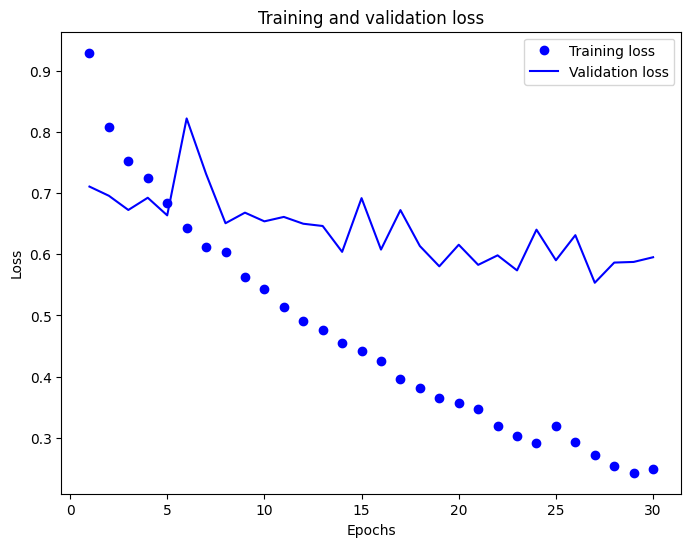

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Compute the final loss and accuracy
final_loss, final_acc = model.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.595279, final accuracy: 0.741145


In [ ]:
predicted_probs2 = model.predict(valid_dataset)
predicted_probs = predicted_probs>=0.5
y = np.concatenate([y for x, y in valid_dataset], axis=0)

print(y[0:20])
print(predicted_probs2[0:20])
print(sum(predicted_probs))

106/106 [==============================] - 5s 40ms/step
[0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 0]
[[0.72870976]
 [0.8626487 ]
 [0.7827252 ]
 [0.2631674 ]
 [0.98654395]
 [0.4960212 ]
 [0.76309663]
 [0.16351902]
 [0.9362241 ]
 [0.41709682]
 [0.4079027 ]
 [0.4838369 ]
 [0.7662487 ]
 [0.831174  ]
 [0.88505286]
 [0.96765625]
 [0.38639778]
 [0.79348165]
 [0.34304243]
 [0.17759466]]
[1]
